In [3]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import sys
import seaborn as sns


In [3]:
from scipy.stats import mode

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.datasets import load_digits, load_sample_image
from sklearn.manifold import TSNE
from sklearn.metrics import cluster, accuracy_score, confusion_matrix


In [7]:


plt.rcParams['figure.figsize'] = [8, 8]
digits = load_digits()
digits.data.shape

(1797, 64)

Let's look at some examples of clustering using K-means.

In the first example, we will attempt to cluster a dataset of digits. This dataset consists of 1,797 images (examples/instances) with 64 attributes (features/variables), where each of those 64 attributes represents the intensity of a pixel in an 8x8 grayscale image.

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_digits_classification_001.png">

# T2.1 - Partition-based Clustering Methods

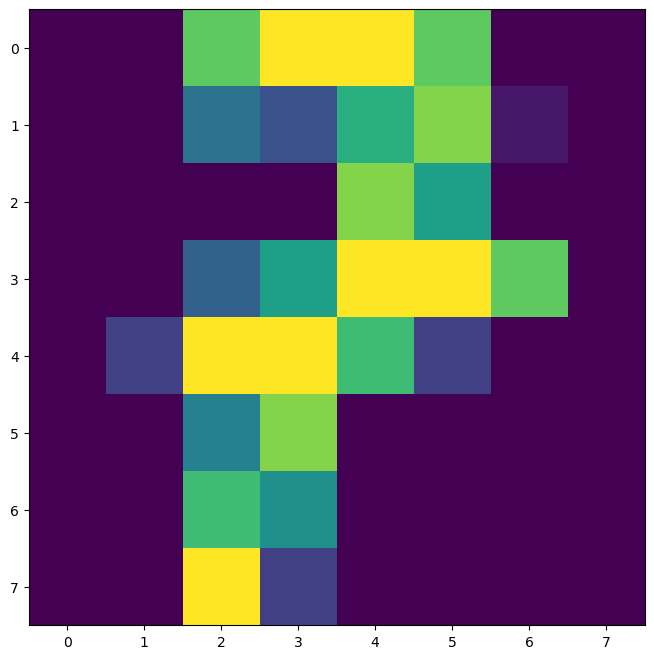

In [21]:
plt.imshow(digits.data[1200].reshape((8,8)))
plt.show()

In [1]:
# we use k-means to perform the clustering

## Your code here ##


Note that the result of the clustering consists of 10 centroids (one for each cluster we requested). Furthermore, since we used the raw pixels, these centroids have the same dimensions as the input images (`10x64`) and represent the "typical" digit of each cluster. Let's visualize them:

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = Kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

As we can see, K-means is able to find the clusters whose centers correspond to the digits from 0 to 9, except for 1 and 8, which it confuses a bit.

Let's compute some intrinsic and extrinsic metrics, as discussed in class, to quantitatively assess the clustering performance.


In [ ]:
print('Completeness score =', completeness_score(digits.target, clusters))
print('Homogeneity =', homogeneity_score(digits.target, clusters))
print('Adjusted Mutual Information =', adjusted_mutual_info_score(digits.target, clusters))


Since we have the true labels, let's compute the accuracy. To do this, we'll use the `accuracy_score` function available in `sklearn.metrics`.

Note that, as we've discussed in class, K-means performs clustering but has no idea which *class* each one belongs to. It simply groups the images by similarity, much like what a *k-nearest neighbors (kNN)* algorithm would do.

Therefore, the first thing we'll do is assign a label to each cluster based on the mode of its elements. That is, we'll look at which element appears most frequently in each cluster, and that will be the assigned label.


In [ ]:
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

And now we can compute the accuracy:

In [ ]:
accuracy_score(digits.target, labels)

And also the confusion matrix:

In [ ]:
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Notice that we managed to correctly classify 80% of our images using a simple K-means without even preprocessing the data. As we observed earlier when plotting the images, the algorithm mainly confuses digits 1 and 8.

What if we applied some kind of preprocessing to improve the results?

Let's see what happens if we use a dimensionality reduction technique known as t-SNE ([https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm](https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm)):


In [ ]:
# We use t-SNE to project the data into another 2-dimensional space
# This step takes a few seconds, be patient :)

tsne = TSNE(n_components=2, random_state=42)
digits_proj = tsne.fit_transform(digits.data)

# Perform clustering

kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(digits_proj)

# Assign labels based on the mode
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute accuracy
accuracy_score(digits.target, labels)

# Display confusion matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');


In [ ]:
accuracy_score(digits.target, labels)

What do you think? Notice the importance of properly preprocessing the data. With this simple decision, we've improved our algorithm's accuracy by 13%.

Don't forget it! ;)


The second example we're going to look at deals with image compression. Yes, it might sound surprising, but clustering techniques can be used for that.

We simply reduce the total number of colors used to represent the image, thereby allowing less memory (bits) to be needed for storage.


In [ ]:
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

Remember that images are represented as matrices of shape `(height, width, channels)`, where the channel values correspond to red/green/blue and range from 0 to 255.


In [ ]:
china.shape

However, we can view this dataset as a three-dimensional point cloud, where each pixel is an instance.

Let's normalize the values between 0 and 1 and convert them into a `[n_instances, 3]` format.


In [ ]:
china.max()

In [ ]:
# normalize the image so that values range between 0 and 1
data = china / 255
data = data.reshape(427 * 640, 3)
data.shape


Now let's visualize the pixels:


In [ ]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data

    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

In [ ]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce from 16 million colors to 16.

Since we're dealing with a large dataset, we'll use a variation of k-means called mini-batch k-Means, which works exactly like k-means but with mini-batches.


In [ ]:
kmeans = ## Your code here ##
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]
print(new_colors.shape)
plot_pixels(data, colors=new_colors, title="Reduced color space: 16 colors")

Perfect. We've just managed to reduce the number of colors to 16, as you can see.

Let's transform the image:


In [ ]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

In [ ]:
# Let's calculate the size of each image
# It takes up approximately 820 KB (819976 bytes)
# import sys
sys.getsizeof(china)


In [ ]:
sys.getsizeof(china_recolored)
# 136 bytes, no llega a 1Kb

There's no doubt that some quality is lost, but keep in mind that we've just managed to compress the image by a factor of roughly 1 million!


The source of these examples, for those who want to check it out:

*   https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
*   https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html
*   https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
